In [109]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from glob import glob
from datetime import datetime, date, time, timedelta
from collections import defaultdict

In [110]:
%config InlineBackend.figure_format = 'svg'

In [111]:
snm_df=pd.read_csv('../data/StationNamesMap2.csv') #, index_col='TurnstileStationName')
snm_df.head()

,TurnstileStationName,StationLocationName
0,1 AV,1st Av
1,103 ST,103rd St
2,103 ST-CORONA,103rd St
3,104 ST,104th St-102nd St
4,110 ST,110th St


In [112]:
snm_df[snm_df.TurnstileStationName.str.match(r'34')].TurnstileStationName.unique()

array(['34 ST-HERALD SQ', '34 ST-HUDSON YD', '34 ST-PENN STA'],
      dtype=object)

In [113]:
snm_df[snm_df.StationLocationName.str.match(r'34')].StationLocationName.unique()

array(['34th St-Herald sq', '34th St-Hudson Yd', '34th St-Penn Stn'],
      dtype=object)

In [114]:
lat_lon_df = pd.read_csv('../data/station_lat_lon2.csv')
lat_lon_df.head()

,Station_Name,Station_Latitude,Station_Longitude
0,Ditmars Blvd,40.775036,-73.912034
1,Astoria Blvd-Hoyt Av,40.770258,-73.917843
2,30 Av-Grand Av,40.766779,-73.921479
3,Broadway,40.761820,-73.925508
4,36 Av-Washington Av,40.756804,-73.929575


In [115]:
lat_lon_df[lat_lon_df.Station_Name.str.match(r'34')].Station_Name.unique()

array(['34th St-Herald sq', '34th St-Penn Stn', '34th St-Hudson Yd'],
      dtype=object)

In [116]:
# Borrowed from Metis class, generates integers.
def generate_numbers():
    """
    An infinite number generator ... stolen from Metis
    """
    x = 0
    while True:
        x += 1
        yield x # instead of return, I use yield, which makes this into a generator!

id_gen = generate_numbers()

In [117]:
# Set the number of rows to display when viewing dataframes / head / tail
pd.set_option("display.max_rows", 101)

In [118]:
# A function for viewing problematic rows. Show preceeding and following rows.
def sample(frame, index):
    """Returns three lines from a dataframe centered around the index parameter"""
    return frame.loc[index-1:index+1]

In [119]:
def am_pm(datetime_series):
    """Creates a Pandas Series object with the same index as the input index and values of
    AM or PM depeneding on the supplied timestamp."""
    s = pd.Series(index=datetime_series.index)
    for index, value in datetime_series.items():
        entry_time = datetime_series[index].time()
        if  entry_time > time(12,0,0) or entry_time == time(0,0,0):
            s[index] = 'PM'
        else:
            s[index] = 'AM'
    return s

In [120]:
def simplify_id(series):
    """Takes a series and changes the values to simple integers. This is to speed up comparisons"""
    s = pd.Series(index=series.index)
    id_set = set(series)
    d = {val : next(id_gen) for val in id_set}
    for index, value in series.iteritems():
        s[index] = d[value]
    return s

In [121]:
# Read data files
# list_of_data_files = sorted(glob('../data/*.txt'))
list_of_data_files = glob('../data/turnstile_190302.txt')
list_of_data_files += glob('../data/turnstile_190309.txt') 
list_of_data_files += glob('../data/turnstile_190316.txt')
list_of_data_files = sorted(list_of_data_files)

# Read data files into pandas dataframes
list_of_dataframes = [pd.read_csv(file) for file in list_of_data_files]
df = pd.concat(list_of_dataframes)
print(df.shape)
df.head()

(608968, 11)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292


In [122]:
df[df.STATION.str.match(r'34')].STATION.unique()

array(['34 ST-HERALD SQ', '34 ST-PENN STA', '34 ST-HUDSON YD'],
      dtype=object)

In [123]:
df = df.merge(snm_df, how='inner', left_on='STATION', right_on='TurnstileStationName')
print(df.shape)
df.head()

(608968, 13)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TurnstileStationName,StationLocationName
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112,59 ST,59th St
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125,59 ST,59th St
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199,59 ST,59th St
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248,59 ST,59th St
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292,59 ST,59th St


In [124]:
df['STATION'] = df['StationLocationName']

In [125]:
df = df.merge(lat_lon_df, how='inner', left_on='STATION', right_on='Station_Name')
print(df.shape)
df.head()

(608968, 16)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TurnstileStationName,StationLocationName,Station_Name,Station_Latitude,Station_Longitude
0,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112,59 ST,59th St,59th St,40.641362,-74.017881
1,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125,59 ST,59th St,59th St,40.641362,-74.017881
2,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199,59 ST,59th St,59th St,40.641362,-74.017881
3,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248,59 ST,59th St,59th St,40.641362,-74.017881
4,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292,59 ST,59th St,59th St,40.641362,-74.017881


In [126]:
df.Station_Name.fillna('', inplace=True)
df[df.Station_Name.str.match(r'34th St-8th Av')]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TurnstileStationName,StationLocationName,Station_Name,Station_Latitude,Station_Longitude


In [127]:
df.drop(['TurnstileStationName', 'StationLocationName', 'Station_Name'], axis=1, inplace=True)

In [128]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Station_Latitude,Station_Longitude
0,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112,40.641362,-74.017881
1,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125,40.641362,-74.017881
2,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199,40.641362,-74.017881
3,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248,40.641362,-74.017881
4,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292,40.641362,-74.017881


In [129]:
df.to_csv('./notrack/agg_station_data.csv', index=False)

In [130]:
# Clean up strange spaces in column names
df.columns = df.columns.str.strip()
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'Station_Latitude', 'Station_Longitude'],
      dtype='object')

In [131]:
# Create a tuples of columns 'C/A', 'UNIT', 'SCP', 'STATION'
df['ID'] = pd.Series(zip(df['C/A'], df['UNIT'], df['SCP'], df['STATION']))

In [132]:
# Replace IDs created above with itengers because processing tuples is really slow
# df['NEW_ID'] = simplify_id(df['ID'])

In [133]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ID
0,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"
1,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"
2,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"
3,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"
4,A002,R051,02-00-00,59th St,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)"


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608968 entries, 0 to 608967
Data columns (total 14 columns):
C/A                  608968 non-null object
UNIT                 608968 non-null object
SCP                  608968 non-null object
STATION              608968 non-null object
LINENAME             608968 non-null object
DIVISION             608968 non-null object
DATE                 608968 non-null object
TIME                 608968 non-null object
DESC                 608968 non-null object
ENTRIES              608968 non-null int64
EXITS                608968 non-null int64
Station_Latitude     608968 non-null float64
Station_Longitude    608968 non-null float64
ID                   608968 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 69.7+ MB


In [135]:
# Filter out df['DESC'] == 'RECOVR AUD'. These entries create large jumps in entry counts
df = df[df['DESC'] != 'RECOVR AUD']

In [136]:
# Add a weekday column
df['DATE_TIME'] = df['DATE'] + ' ' + df['TIME']
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['WEEKDAY'] = df['DATE_TIME'].dt.day_name()

In [137]:
# Drop unneeded columns
df.drop(['LINENAME', 'DIVISION', 'DESC', 'C/A', 'UNIT', 'SCP', 'TIME'], inplace=True, axis=1)

In [138]:
# Limit to one station for simplicity
# df = df[df['STATION'] == '59 ST']
df.head()

,STATION,DATE,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ID,DATE_TIME,WEEKDAY
0,59th St,02/23/2019,6955483,2359112,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 03:00:00,Saturday
1,59th St,02/23/2019,6955494,2359125,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 07:00:00,Saturday
2,59th St,02/23/2019,6955554,2359199,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 11:00:00,Saturday
3,59th St,02/23/2019,6955714,2359248,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 15:00:00,Saturday
4,59th St,02/23/2019,6956004,2359292,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 19:00:00,Saturday


In [139]:
# cache the number of rows for a future sanity check
rows_in_orig = df.shape[0]

In [140]:
# Create a disctiondary of dataframes for each turnstile id for entry count processing
# dict_of_ids = {id : df[df['NEW_ID'] == id] for id in df['NEW_ID'].unique()}
dict_of_ids = {id : df[df['ID'] == id] for id in df['ID'].unique()}

In [141]:
# Sanity check to be sure things worked
# dict_of_ids[8210.0].head()

In [142]:
# Create Entry counts based on subtracting a an entry count from the entry count in the next row.
for key, frame in dict_of_ids.items():
    dict_of_ids[key]['ENTRY_COUNT'] = abs(frame['ENTRIES'] - frame['ENTRIES'].shift(1)) + \
                                        abs(frame['EXITS'] - frame['EXITS'].shift(1))
    dict_of_ids[key]['ENTRY_COUNT'].fillna(0, inplace=True)

/Applications/conda/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [143]:
# Recombine the dataframe from the dictionary of dataframes, now with entry counts
df = pd.concat(dict_of_ids.values())

In [144]:
# Check the number of rows to be sure we didn't gain or lose anything
assert(df.shape[0] == rows_in_orig)

In [145]:
df.shape

(606275, 10)

In [146]:
# Filter out counts larger than 300 because they are almost always turnstile resets.
df = df[df['ENTRY_COUNT'] < 3000]

In [147]:
# Create a DATE column from the DATE_TIME timestamp.
df['DATE'] = df['DATE_TIME'].dt.date

In [148]:
df.head()

,STATION,DATE,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ID,DATE_TIME,WEEKDAY,ENTRY_COUNT
0,59th St,2019-02-23,6955483,2359112,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 03:00:00,Saturday,0.0
1,59th St,2019-02-23,6955494,2359125,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 07:00:00,Saturday,24.0
2,59th St,2019-02-23,6955554,2359199,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 11:00:00,Saturday,134.0
3,59th St,2019-02-23,6955714,2359248,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 15:00:00,Saturday,209.0
4,59th St,2019-02-23,6956004,2359292,40.641362,-74.017881,"(A002, R051, 02-00-00, 59th St)",2019-02-23 19:00:00,Saturday,334.0


In [149]:
df[(df['ENTRY_COUNT'] > 2000) & (df.STATION == 'World Trade Center')]

,STATION,DATE,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ID,DATE_TIME,WEEKDAY,ENTRY_COUNT
319039,World Trade Center,2019-02-25,70,5316829,40.712582,-74.009781,"(PTH03, R552, 00-00-0A, World Trade Center)",2019-02-25 20:59:16,Monday,2257.0
319050,World Trade Center,2019-02-27,70,5326811,40.712582,-74.009781,"(PTH03, R552, 00-00-0A, World Trade Center)",2019-02-27 19:11:16,Wednesday,2152.0
319056,World Trade Center,2019-02-28,70,5332721,40.712582,-74.009781,"(PTH03, R552, 00-00-0A, World Trade Center)",2019-02-28 20:23:16,Thursday,2347.0
319916,World Trade Center,2019-03-04,70,5345930,40.712582,-74.009781,"(PTH03, R552, 00-00-0A, World Trade Center)",2019-03-04 21:13:16,Monday,2034.0
319084,World Trade Center,2019-02-26,151420,270871,40.712582,-74.009781,"(PTH03, R552, 00-01-00, World Trade Center)",2019-02-26 17:58:31,Tuesday,2203.0
...,...,...,...,...,...,...,...,...,...,...
337189,World Trade Center,2019-03-05,8250,7509,40.712582,-74.009781,"(PTH22, R540, 00-02-01, World Trade Center)",2019-03-05 19:26:03,Tuesday,2026.0
335431,World Trade Center,2019-02-26,89337,72028,40.712582,-74.009781,"(PTH22, R540, 00-02-02, World Trade Center)",2019-02-26 20:15:19,Tuesday,2128.0
339397,World Trade Center,2019-03-09,197,5,40.712582,-74.009781,"(PTH22, R540, 00-03-05, World Trade Center)",2019-03-09 18:01:02,Saturday,2052.0
336478,World Trade Center,2019-02-27,1273341,521286,40.712582,-74.009781,"(PTH22, R540, 00-05-06, World Trade Center)",2019-02-27 19:24:18,Wednesday,2002.0


In [150]:
sample(df, 1359)

,STATION,DATE,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ID,DATE_TIME,WEEKDAY,ENTRY_COUNT
1358,59th St,2019-02-25,4597346,18149443,40.641362,-74.017881,"(R244A, R050, 01-00-00, 59th St)",2019-02-25 11:00:00,Monday,2326.0
1359,59th St,2019-02-25,4597490,18150190,40.641362,-74.017881,"(R244A, R050, 01-00-00, 59th St)",2019-02-25 15:00:00,Monday,891.0
1360,59th St,2019-02-25,4598134,18150919,40.641362,-74.017881,"(R244A, R050, 01-00-00, 59th St)",2019-02-25 19:00:00,Monday,1373.0


In [151]:
# Sum up entry counts by date and weekday. This is a little redundant, but the WEEKDAY
# column is needed for later processing.
gp_date_weekday = df.groupby(['STATION', 'DATE', 'WEEKDAY'], as_index=False).sum()
# gp_date_weekday = df.groupby(['STATION', 'DATE'], as_index=False).sum()

In [152]:
gp_date_weekday[gp_date_weekday.STATION == 'World Trade Center']

,STATION,DATE,WEEKDAY,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ENTRY_COUNT
7031,World Trade Center,2019-02-23,Saturday,14238065478,11348311562,58341.130006,-106056.016173,102692.0
7032,World Trade Center,2019-02-24,Sunday,14237457207,11349306965,58829.680990,-106944.133545,80543.0
7033,World Trade Center,2019-02-25,Monday,14246355179,11346791433,59196.094228,-107610.221574,397590.0
7034,World Trade Center,2019-02-26,Tuesday,14244818870,11359019103,58585.405498,-106500.074859,424435.0
7035,World Trade Center,2019-02-27,Wednesday,14238209697,11350988400,58666.830662,-106648.094421,428287.0
7036,World Trade Center,2019-02-28,Thursday,15837522978,13190210330,59358.944556,-107906.260698,420311.0
7037,World Trade Center,2019-03-01,Friday,14237478518,11349817542,57649.016112,-104797.849896,377445.0
7038,World Trade Center,2019-03-02,Saturday,14242414497,11352157763,58015.429350,-105463.937925,123810.0
7039,World Trade Center,2019-03-03,Sunday,14236703932,11343067139,57852.579022,-105167.898801,90158.0
7040,World Trade Center,2019-03-04,Monday,15840366489,13187953610,59155.381646,-107536.211793,311491.0


In [153]:
# Calculate the mean number of entries for each station.
daily_mean_by_station = gp_date_weekday.groupby('STATION', as_index=False).mean()

In [154]:
# Round off the mean values as they have a crazy number of decimal places.
daily_mean_by_station['ENTRY_COUNT'] = daily_mean_by_station['ENTRY_COUNT'].round(0)
# daily_mean_by_station.sort_values('ENTRY_COUNT', ascending=False, inplace=True)

In [155]:
# Create a new dataframe of the file largest stations by entry count
five_largest = daily_mean_by_station.nlargest(5, 'ENTRY_COUNT').sort_values('ENTRY_COUNT', ascending=False)
station = five_largest.STATION
entry_counts = five_largest.ENTRY_COUNT
five_largest.to_csv('five_largest_stations.csv')


In [164]:
top_20 = daily_mean_by_station.nlargest(20, 'ENTRY_COUNT')
top_20.head()

,STATION,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ENTRY_COUNT
335,World Trade Center,1.454613e+10,1.170279e+10,58407.045615,-106175.841533,318639.0
57,34th St-Penn Stn,2.264152e+10,2.401313e+10,24413.354415,-44327.689910,271958.0
211,Grand Central-42nd St,1.383058e+10,1.019805e+10,15873.787032,-28815.743650,221230.0
62,42nd St,5.742116e+10,4.640477e+10,17671.204254,-32079.835104,219760.0
55,34th St-Herald sq,3.009513e+10,3.769739e+10,14262.401650,-25895.738050,195278.0


In [165]:
top_20.to_csv('../data/station_daily_mean_for_map.csv')

In [156]:
five_largest.head()

,STATION,ENTRIES,EXITS,Station_Latitude,Station_Longitude,ENTRY_COUNT
335,World Trade Center,1.454613e+10,1.170279e+10,58407.045615,-106175.841533,318639.0
57,34th St-Penn Stn,2.264152e+10,2.401313e+10,24413.354415,-44327.689910,271958.0
211,Grand Central-42nd St,1.383058e+10,1.019805e+10,15873.787032,-28815.743650,221230.0
62,42nd St,5.742116e+10,4.640477e+10,17671.204254,-32079.835104,219760.0
55,34th St-Herald sq,3.009513e+10,3.769739e+10,14262.401650,-25895.738050,195278.0


In [157]:
# Create a reversed index so that stations display in descending order in the bar graph
new_index = list(reversed(station.index))

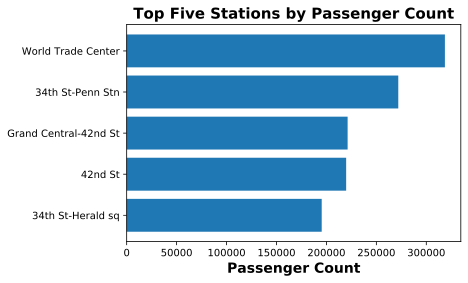

In [158]:
# Plot the bar chart of the top 5 stations
plt.barh(station[new_index], entry_counts[new_index]);
plt.xlabel('Passenger Count', fontsize = 14, weight = 'bold',color='black');
plt.title('Top Five Stations by Passenger Count', fontsize = 15, weight = 'bold',color='black')
plt.savefig('top_five_stations_barh.png')

In [159]:
# Create a series of the top ten stations
top_ten_stations = daily_mean_by_station.nlargest(10, 'ENTRY_COUNT').STATION
top_ten_stations

335       World Trade Center
57          34th St-Penn Stn
211    Grand Central-42nd St
62                   42nd St
55         34th St-Herald sq
93                   86th St
47                   23rd St
17      14th St-Union Square
316     Times Square-42nd St
206                Fulton St
Name: STATION, dtype: object

In [160]:
# top_ten_series = pd.Series(gp_top_ten_weekday.STATION.unique())[[2, 9, 7, 3, 1, 4, 0, 8, 6, 5]]

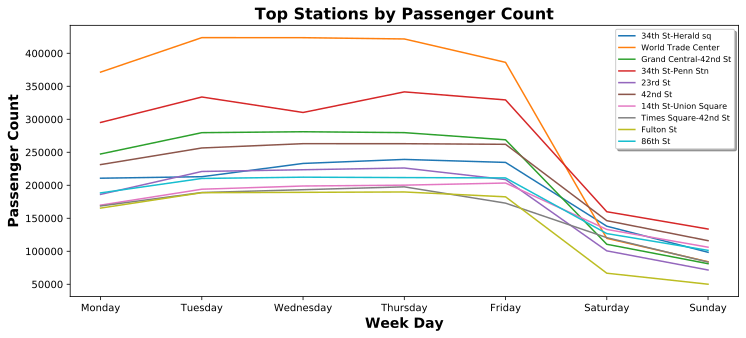

In [161]:
top_ten_df = gp_date_weekday[gp_date_weekday['STATION'].isin(top_ten_stations)]
gp_top_ten_weekday = top_ten_df.groupby(['STATION', 'WEEKDAY'], as_index=False).mean()
# gp_top_ten_weekday.drop(['ENTRIES', 'NEW_ID'], axis=1, inplace=True)
top_ten_series = pd.Series(gp_top_ten_weekday.STATION.unique())[[2, 9, 7, 3, 1, 4, 0, 8, 6, 5]]
gp_top_ten_weekday.drop(['ENTRIES'], axis=1, inplace=True)
gp_top_ten_weekday.head(2)
test = gp_top_ten_weekday.copy()
test.set_index('WEEKDAY', inplace=True)
wd_idx = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
gp_top_ten_weekday = test.copy()
legend_names = []
plt.figure(figsize = [12,5])
# for station in gp_top_ten_weekday.STATION.unique():
for station in top_ten_series:
    tmp_df = gp_top_ten_weekday[gp_top_ten_weekday['STATION'] == station]
    plt.plot(tmp_df['ENTRY_COUNT'][wd_idx])
    legend_names.append(station)
plt.ylabel('Passenger Count', fontsize = 14, weight = 'bold',color='black');
plt.title('Top Stations by Passenger Count', fontsize = 16, weight = 'bold',color='black')
plt.xlabel('Week Day', fontsize = 14, weight = 'bold',color='black')
# plt.legend(legend_names, shadow=True, loc = 0, fontsize=8);
plt.legend(top_ten_series, shadow=True, loc = 0, fontsize=8);
plt.savefig('top_stations.png')

In [162]:
gp_top_ten_weekday.head(20)

,STATION,EXITS,Station_Latitude,Station_Longitude,ENTRY_COUNT
WEEKDAY,,,,,
Friday,14th St-Union Square,1.883089e+09,9110.988528,-16549.085707,203386.000000
Monday,14th St-Union Square,1.915886e+09,9260.348995,-16820.382194,169949.333333
Saturday,14th St-Union Square,1.783613e+09,9178.879649,-16672.402292,133021.333333
Sunday,14th St-Union Square,1.918360e+09,9287.505444,-16869.708828,106137.333333
Thursday,14th St-Union Square,1.920324e+09,9287.505444,-16869.708828,200165.333333
Tuesday,14th St-Union Square,1.914924e+09,9260.348995,-16820.382194,194029.000000
Wednesday,14th St-Union Square,2.024454e+09,9884.947315,-17954.894776,198882.666667
Friday,23rd St,4.392764e+10,17790.368977,-32308.680213,208627.666667
Monday,23rd St,4.367416e+10,17803.949411,-32333.343328,186185.333333


***